In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_dataset(dataset_path, img_size=(72, 72)):
    images = []
    labels = []

    for label in os.listdir(dataset_path):
        # Ensure label is a directory
        class_path = os.path.join(dataset_path, label)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                # Load and preprocess the image
                img_path = os.path.join(class_path, img_file)
                img = load_img(img_path, target_size=img_size, color_mode='grayscale')
                img_array = img_to_array(img)
                img_array = img_array / 255.0

                images.append(img_array)
                labels.append(label)

    # Convert lists to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    return X, y_categorical, label_encoder

# Load the dataset
dataset_path = '../data/recorded_specs'
X, y, label_encoder = load_dataset(dataset_path)

X.shape, y.shape


((159, 72, 72, 1), (159, 3))

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))  # y.shape[1] is the number of classes

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
4/4 [==============================] - 1s 180ms/step - loss: 1.1595 - accuracy: 0.3386 - val_loss: 1.0968 - val_accuracy: 0.3438
Epoch 2/10
4/4 [==============================] - 0s 99ms/step - loss: 1.0933 - accuracy: 0.3465 - val_loss: 1.0639 - val_accuracy: 0.3438
Epoch 3/10
4/4 [==============================] - 0s 75ms/step - loss: 1.0556 - accuracy: 0.5039 - val_loss: 1.0325 - val_accuracy: 0.6875
Epoch 4/10
4/4 [==============================] - 0s 50ms/step - loss: 1.0246 - accuracy: 0.5433 - val_loss: 0.9697 - val_accuracy: 0.7500
Epoch 5/10
4/4 [==============================] - 0s 74ms/step - loss: 0.9496 - accuracy: 0.6142 - val_loss: 0.8778 - val_accuracy: 0.7188
Epoch 6/10
4/4 [==============================] - 0s 90ms/step - loss: 0.8436 - accuracy: 0.6535 - val_loss: 0.7551 - val_accuracy: 0.7188
Epoch 7/10
4/4 [==============================] - 0s 105ms/step - loss: 0.8318 - accuracy: 0.6378 - val_loss: 0.6758 - val_accuracy: 0.7188
Epoch 8/10
4/4 [=========

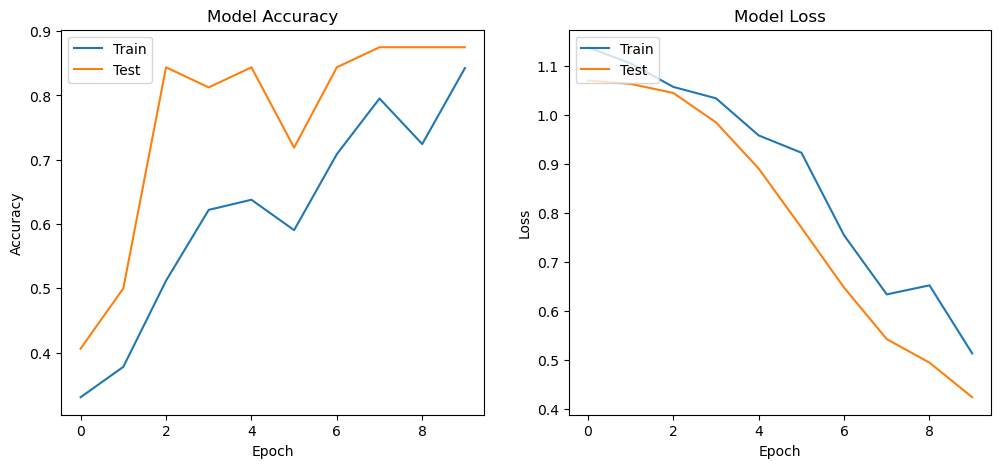

In [3]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

1/1 [==============================] - 0s 152ms/step


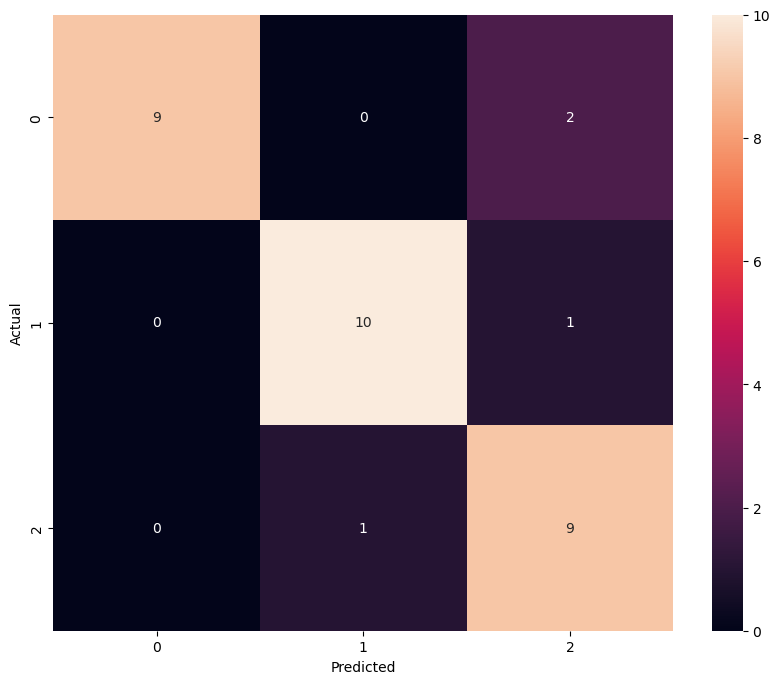

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the test dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [9]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

class CNNHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=512, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5]),
            activation='relu',
            input_shape=(72, 72, 1)
        ))
        model.add(MaxPooling2D())
        model.add(Flatten())
        model.add(Dense(
            units=hp.Int('units', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
        model.add(Dense(3, activation='softmax'))
        model.compile(
            optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel()

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='keras_tuner_cnn'
)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.7692307829856873

Best val_accuracy So Far: 0.8461538553237915
Total elapsed time: 00h 09m 58s


In [18]:
tuner.get_best_hyperparameters()[0].values

{'filters': 320,
 'kernel_size': 3,
 'units': 512,
 'learning_rate': 0.00010250711301503711}

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# A more complex CNN architecture
model = Sequential()

# First convolutional block
model.add(Conv2D(320, (3, 3), activation='relu', input_shape=(72, 72, 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(320, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Second convolutional block
model.add(Conv2D(320, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(320, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Third convolutional block
model.add(Conv2D(320, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(320, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flattening and dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(3, activation='softmax')) # 3 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 72, 72, 320)       3200      
                                                                 
 batch_normalization (BatchN  (None, 72, 72, 320)      1280      
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 72, 72, 320)       921920    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 36, 36, 320)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 320)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 36, 36, 320)      

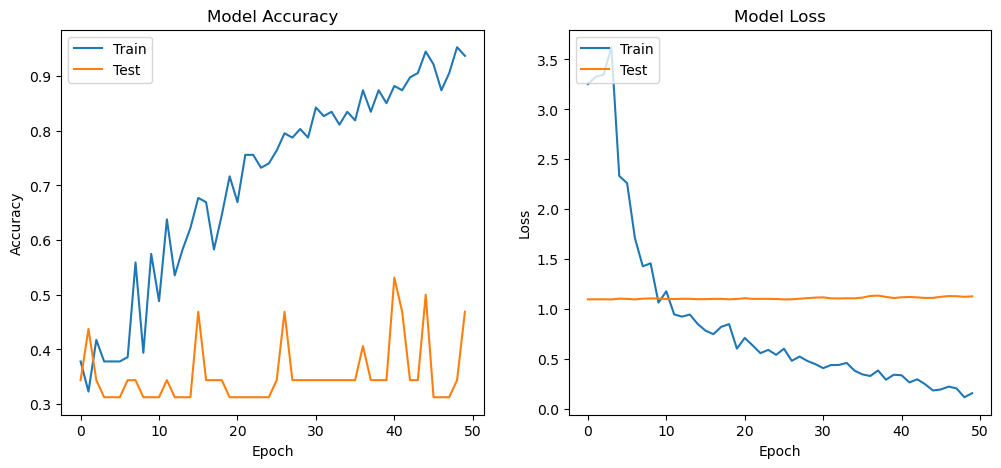

In [4]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

1/1 [==============================] - 2s 2s/step


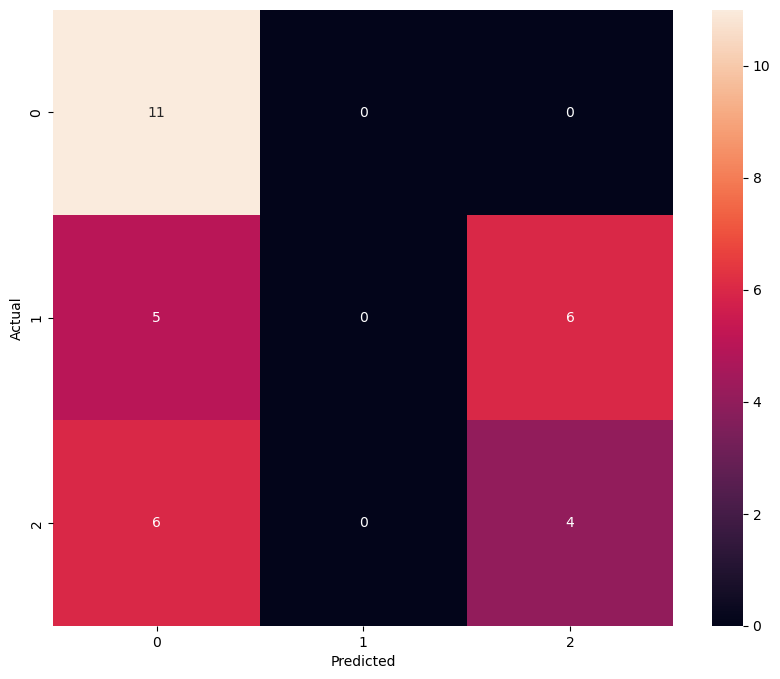

: 

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the test dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Define the CNN model architecture
model = Sequential()

# Add a convolutional layer with L2 regularization
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(72, 72, 1), kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Add a second convolutional layer with L2 regularization
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Add a dense layer with L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

# Output layer with softmax activation for classification
model.add(Dense(y.shape[1], activation='softmax'))  # y.shape[1] is the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Add an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history_3 = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 70, 70, 64)        640       
                                                                 
 batch_normalization_2 (Batc  (None, 70, 70, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 35, 35, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 33, 33, 128)       73856     
                                                                 
 batch_normalization_3 (Batc  (None, 33, 33, 128)      512       
 hNormalization)                                                 
                                                      

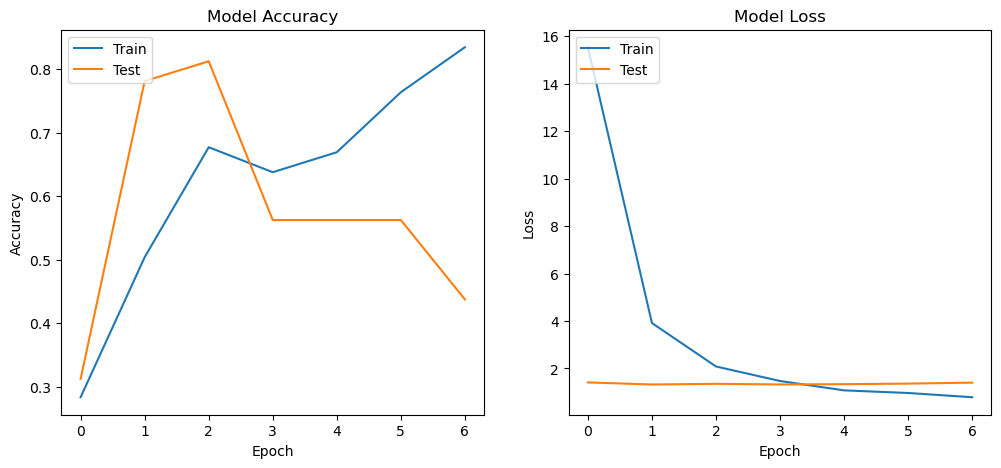

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

1/1 [==============================] - 0s 50ms/step


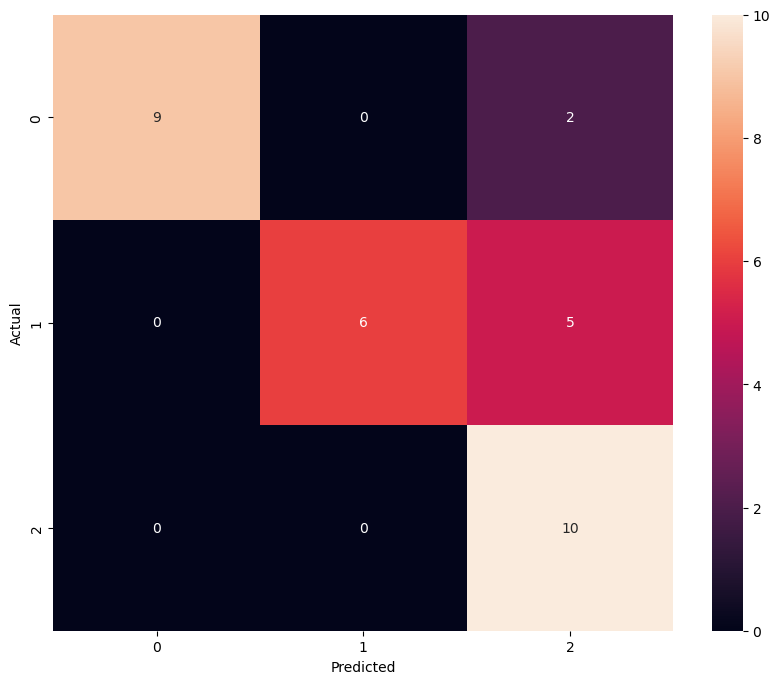

: 

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the test dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert test observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
